In [197]:
import seaborn as sns
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

In [198]:
df = pd.read_csv('data/housing_processed.csv')

df = df.drop(columns=['Unnamed: 0'])

y = df['median_house_value']
X = df.drop(columns='median_house_value')

In [199]:
df

,median_income,median_house_value,ocean_proximity,avg_rooms,avg_population
0,8.3252,452600.0,NEAR BAY,6.984127,2.555556
1,8.3014,358500.0,NEAR BAY,6.238137,2.109842
2,7.2574,352100.0,NEAR BAY,8.288136,2.802260
3,5.6431,341300.0,NEAR BAY,5.817352,2.547945
4,3.8462,342200.0,NEAR BAY,6.281853,2.181467
...,...,...,...,...,...
18802,1.5603,78100.0,INLAND,5.045455,2.560606
18803,2.5568,77100.0,INLAND,6.114035,3.122807
18804,1.7000,92300.0,INLAND,5.205543,2.325635
18805,1.8672,84700.0,INLAND,5.329513,2.123209


In [200]:
encoder = OneHotEncoder(handle_unknown='error', sparse_output=False)
one_hot = encoder.fit_transform(X[['ocean_proximity']])
column_names = encoder.get_feature_names_out()

OH_cols = pd.DataFrame(one_hot, columns=column_names)
OH_cols.index = X.index

num_X = X.drop('ocean_proximity', axis=1)

OH_X = pd.concat([num_X, OH_cols], axis=1)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(OH_X, y, test_size=0.2, random_state=42)

In [202]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).tolist()
X_test_scaled = scaler.transform(X_test).tolist()

y_test_unscaled = y_test.tolist()
y_train_unscaled = y_train.tolist()

In [260]:
# Parameters

num_iter = 500
alpha = 0.01

# Vanilla Python Implementation

The code that follows is my own implementation of Linear Regression using Gradient Descent in Vanilla Python

In [204]:
def dot(w, X):
    ans = 0
    for i in range(len(w)):
        ans += (w[i] * X[i])

    return ans

In [205]:
def calculate_cost(X, y, m, w, b):
    ans = 0
    for i in range(m):
        ans += (dot(w, X[i]) + b - y[i]) ** 2
    
    J = (ans / (2 * m))
    return J

In [206]:
def gradient_descent(X, y, m, w, b):
    w_upd = []
    for j in range(len(w)):
        ans = 0
        for i in range(m):
            ans += (dot(w, X[i]) + b - y[i]) * X[i][j]

        w_upd.extend([ans / m])
    
    ans = 0
    for i in range(m):
        ans += (dot(w, X[i]) + b - y[i])
    b_upd = (ans / m)

    return (w_upd, b_upd)

In [231]:
w_init = [0] * len(X_train_scaled[1])
b_init = 0

cost_history_pure = []

start_time = time.time()

for counter in range(num_iter):
    J = calculate_cost(X_train_scaled, y_train_unscaled, len(X_train_scaled), w_init, b_init)
    w_upd, b_upd = gradient_descent(X_train_scaled, y_train_unscaled, len(X_train_scaled), w_init, b_init)

    cost_history_pure.append(J)

    for i in range(len(w_init)):
        w_init[i] -= (alpha * w_upd[i])
    b_init -= (alpha * b_upd)

end_time = time.time()

In [232]:
print(f'Runtime for Pure Python Implementation for {num_iter} epochs: {end_time - start_time} seconds')

Runtime for Pure Python Implementation for 3000 epochs: 283.38219022750854 seconds


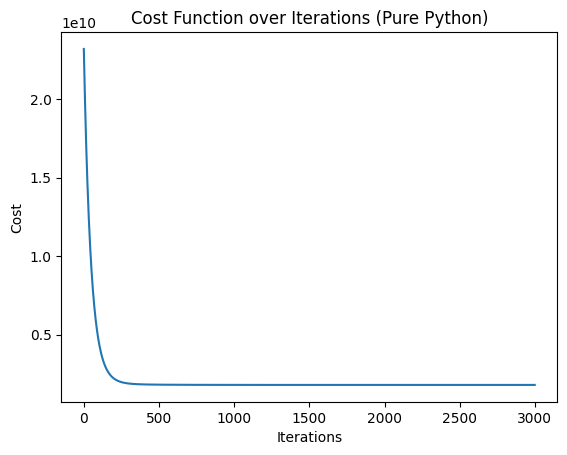

In [237]:
plt.plot(cost_history_pure)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost Function over Iterations (Pure Python)")
plt.savefig('pure')
plt.show()

In [210]:
print(J)
print(calculate_cost(X_train_scaled, y_train_unscaled, len(X_train_scaled), [0,0,0,0,0,0,0,0], 0))
print(w_init, b_init)

1799605834.4836214
23206909538.717247
[59781.48744604445, -8410.302933425763, -21639.78197686287, 10941.206443429548, -22798.866975321638, 3830.933197778796, 7423.18008375263, 8676.240140836944] 192601.46214687717


In [211]:
def mean_absolute_error(y_true, y_pred):
    return sum(abs(yt - yp) for yt, yp in zip(y_true, y_pred)) / len(y_true)

def r2_score(y_true, y_pred):
    mean_y = sum(y_true) / len(y_true)
    ss_total = sum((yt - mean_y)**2 for yt in y_true)
    ss_res = sum((yt - yp)**2 for yt, yp in zip(y_true, y_pred))
    return 1 - (ss_res / ss_total)

def root_mean_squared_error(y_true, y_pred):
    mse = sum((yt - yp)**2 for yt, yp in zip(y_true, y_pred)) / len(y_true)
    return mse**0.5

In [212]:
y_pred = [sum(xi * wi for xi, wi in zip(x, w_init)) + b_init for x in X_test_scaled]
print("RMSE:", root_mean_squared_error(y_test_unscaled, y_pred))
print("MAE:", mean_absolute_error(y_test_unscaled, y_pred))
print("R² Score:", r2_score(y_test_unscaled, y_pred))

RMSE: 59938.39366764223
MAE: 44079.524405786506
R² Score: 0.6144675729014736


# Numpy Accelerated Implementation
The code that follows is my own implementation of Linear Regression using Gradient Descent, with the speed of Numpy

In [213]:
def calculate_cost_np(X, y, m, w, b):

    predictions = np.dot(X, w) + b
    errors = predictions - y
    ans = np.sum(errors ** 2)
    
    J = (ans / (2 * m))
    return J

In [214]:
def gradient_descent_np(X, y, m, w, b):
    predictions = np.dot(X, w) + b
    errors = predictions - y
    
    w_upd = np.dot(X.T, errors) / m
    b_upd = np.sum(errors) / m

    return (w_upd, b_upd)

In [261]:
w_init_np = np.zeros(shape=X_train.shape[1])
b_init_np = 0

cost_history_np = []

start_time = time.time()

X_train_np = np.array(X_train_scaled)
X_test_np = np.array(X_test_scaled)
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

for counter in range(num_iter):
    J = calculate_cost_np(X_train_np, y_train_np, len(X_train), w_init_np, b_init_np)
    w_upd, b_upd = gradient_descent_np(X_train_np, y_train_np, len(X_train), w_init_np, b_init_np)

    cost_history_np.append(J)

    w_init_np -= (alpha * w_upd)
    b_init_np -= (alpha * b_upd)

end_time = time.time()

In [262]:
print(f'Runtime for Numpy Accelerated Implementation for {num_iter} epochs: {end_time - start_time} seconds')

Runtime for Numpy Accelerated Implementation for 500 epochs: 0.09881591796875 seconds


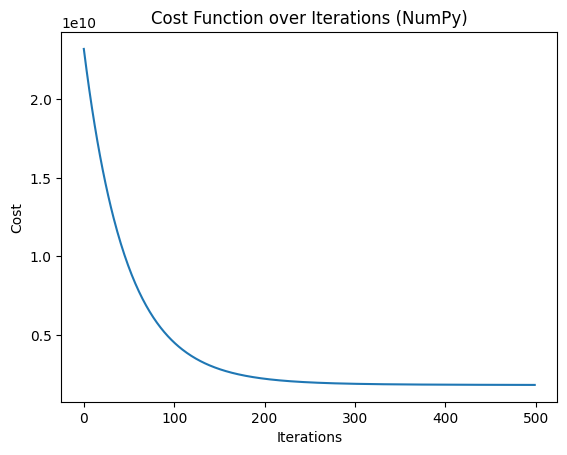

In [263]:
plt.plot(cost_history_np)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost Function over Iterations (NumPy)")
plt.savefig('numpy.png')
plt.show()

In [264]:
print(J)
print(calculate_cost_np(X_train_np, y_train_np, len(X_train_np), np.zeros(shape=X_train.shape[1]), 0))
print(w_init, b_init)

1816215231.8899398
23206909538.717247
[59781.48744604445, -8410.302933425763, -21639.78197686287, 10941.206443429548, -22798.866975321638, 3830.933197778796, 7423.18008375263, 8676.240140836944] 192601.46214687717


In [220]:
y_pred = [sum(xi * wi for xi, wi in zip(x, w_init)) + b_init for x in X_test_np]

print("RMSE:", root_mean_squared_error(y_test_np, y_pred))
print("MAE:", mean_absolute_error(y_test_np, y_pred))
print("R² Score:", r2_score(y_test_np, y_pred))

RMSE: 59938.393667642194
MAE: 44079.52440578654
R² Score: 0.6144675729014744


# Scikit Learn Implementation
Implementing Linear Regression usking sklearn.linear_model.LinearRegression()

In [221]:
start_time = time.time()

model = LinearRegression()
model.fit(X_train, y_train)

end_time = time.time()

In [222]:
print(f'Runtime for Scikit Learn Implementation for {num_iter} epochs: {end_time - start_time} seconds')

Runtime for Scikit Learn Implementation for 3000 epochs: 0.0056836605072021484 seconds


In [223]:
y_pred = model.predict(X_test)

print("RMSE:", root_mean_squared_error(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

RMSE: 59938.49824327341
MAE: 44079.34472970036
R² Score: 0.6144662276090955
